In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime
#%%
#寫法邏輯
#IVOL_weights = IVOL_weights(rebalance_date, top_stocks_name, period_TSE_Stock_Price, period_TW50_TR)
#input 1: 調整日的日期
#input 2: input tickers need to be sorted
#input 3: 將調整日的日期往前一年作為訓練選股
#input 4: 計算這些股票的選股
#input 5: return data
#data: slice return data
#def rebalance date, tickers, return data, 
#output: 

#years = [2017, 2018, 2019, 2020, 2021]
#dt_years_first_day = [pd.to_datetime(year, format='%Y') for year in years]
#dt_years_end_day = [pd.to_datetime(year + 1, format='%Y') - DateOffset(days=1) for year in years]



def IVOL_weights(backtest_end_day, tickers, period_TSE_TR, period_TW50_TR, top_weights):
    #backtest_first_day = backtest_end_day - DateOffset(years=1)
    data_return = pd.concat([period_TSE_TR, period_TW50_TR],axis=1)
    date = str(data_return.index[len(data_return)-1]).split(' ')[0]
    if date == '2002-07-04':
        date = '2002-07-05'
    print(f'{date}')
    
    first_q_dates = data_return.groupby(data_return.index.to_period('Q')).apply(lambda x: x.index[0])
    first_q_dates = sorted(first_q_dates.tolist())

    end_q_dates = data_return.groupby(data_return.index.to_period('Q')).apply(lambda x: x.index[-1])
    end_q_dates = sorted(end_q_dates.tolist())
    
    first_m_dates = data_return.groupby(data_return.index.to_period('M')).apply(lambda x: x.index[0])
    first_m_dates = sorted(first_m_dates.tolist())
    
    end_m_dates = data_return.groupby(data_return.index.to_period('M')).apply(lambda x: x.index[-1])
    end_m_dates = sorted(end_m_dates.tolist())
    
    prev_rebalance_date = data_return.index[0]
    monthly_returns = [] #用來儲存每月的報酬
    
    for end_m_date in end_m_dates:
        
        period_return = data_return[prev_rebalance_date: end_m_date]
        period_cumulative_return = period_return.add(1).prod()-1
        monthly_returns.append(period_cumulative_return)        
        
        # Update the prev_rebalance_date for the next interval
        prev_rebalance_date = end_m_date + DateOffset(days=1)
    
    # 初始化 LinearRegression 模型
    lm = LinearRegression()
    
    # 創建一個儲存MSE的字典
    residual_dict_3M = {}
    residual_dict_6M = {}
    residual_dict_12M = {}
    
    # 假設 monthly_return 是一個包含 12 個 pandas Series 的列表
    # 每個 Series 包含多列（一列代表一個日期）和多行（一行代表一個股票）
    
    # 獲取所有的股票名稱 (排除 "TSE")
    stock_names = monthly_returns[0].drop("TW50TR_Return").index

    # 進行迴歸分析
    for stock in stock_names:
        y = np.array([monthly_return["TW50TR_Return"] for monthly_return in monthly_returns])
        X = np.array([monthly_return[stock] for monthly_return in monthly_returns]).reshape(-1, 1)
        
        # 訓練模型
        lm.fit(X, y)
        
        # 進行預測
        y_pred = lm.predict(X)
        
        # 計算MSE
        residual = y_pred - y
        
        # 將MSE儲存到字典
        residual_dict_12M[stock] = residual.std()
        
        y = y[-6:]
        X = X[-6:]
        
        # 訓練模型
        lm.fit(X, y)
        
        # 進行預測
        y_pred = lm.predict(X)
        
        # 計算MSE
        residual = y_pred - y
        
        # 將MSE儲存到字典
        residual_dict_6M[stock] = residual.std()

        y = y[-3:]
        X = X[-3:]
        
        # 訓練模型
        lm.fit(X, y)
        
        # 進行預測
        y_pred = lm.predict(X)
        
        # 計算MSE
        residual = y_pred - y
        
        # 將MSE儲存到字典
        residual_dict_3M[stock] = residual.std()

    stdev_dict_3M = {}
    stdev_dict_6M = {}
    stdev_dict_12M = {}
    
    for stock in stock_names:
        stock_return = data_return.loc[:,stock]
        quarter_stdev = stock_return[-60:].std()
        semiannual_stdev = stock_return[-120:].std()
        year_stdev = stock_return.std()
        stdev_dict_3M[stock] = quarter_stdev
        stdev_dict_6M[stock] = semiannual_stdev
        stdev_dict_12M[stock] = year_stdev
    
    
    cummulative_return_3M = data_return.loc[:,stock_names][:-60].add(1).prod() - 1
    cummulative_return_6M = data_return.loc[:,stock_names][:-120].add(1).prod() - 1
    cummulative_return_12M = data_return.loc[:,stock_names][:].add(1).prod() - 1
    
    #將MA因子改成市值因子!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # MA60_price = data_return.loc[:,stock_names][:].add(1).cumprod()
    # MA60 = MA60_price.rolling(window = 60).mean()
    # MA60_result = MA60_price.iloc[-1] / MA60.iloc[-1]
    mkt_ratio = pd.read_csv('TEJ_50_mkt_ratio.txt', delimiter='\t')
    mkt_ratio['年月日'] = pd.to_datetime(mkt_ratio['年月日'], format='%Y/%m/%d')
    mkt_ratio['成份股'] = mkt_ratio['成份股'].str.split(' ', expand=True)[0] + '.TW'
    filtered_mkt_ratio = mkt_ratio[mkt_ratio['成份股'].isin(tickers)]
    #篩選特定日期的資料
    filtered_mkt_ratio = filtered_mkt_ratio[filtered_mkt_ratio['年月日'] == str(date)]
    filtered_mkt_ratio = filtered_mkt_ratio.set_index('成份股', drop=True)
    MA60_result = filtered_mkt_ratio['前日市值比重']
    
    #%%
    # 將 MSE 字典轉換為 DataFrame 以便查看
    residual_dict_3M = pd.DataFrame(list(residual_dict_3M.items()), columns=['Stock', 'Residual'])
    residual_dict_6M = pd.DataFrame(list(residual_dict_6M.items()), columns=['Stock', 'Residual'])
    residual_dict_12M = pd.DataFrame(list(residual_dict_12M.items()), columns=['Stock', 'Residual'])

    #print(residual_dict)
    
    # 對 Residual 列進行排序，預設是升序
    residual_dict_3M = residual_dict_3M.sort_values(by='Residual')
    residual_dict_6M = residual_dict_6M.sort_values(by='Residual')
    residual_dict_12M = residual_dict_12M.sort_values(by='Residual')
    
    residual_dict_3M.set_index('Stock', inplace=True)
    residual_dict_6M.set_index('Stock', inplace=True)
    residual_dict_12M.set_index('Stock', inplace=True)
    
    residual_dict_3M['RANK'] = residual_dict_3M['Residual'].rank()
    residual_dict_6M['RANK'] = residual_dict_6M['Residual'].rank()
    residual_dict_12M['RANK'] = residual_dict_12M['Residual'].rank()

    residual_dict = pd.DataFrame(residual_dict_3M['RANK'] + residual_dict_6M['RANK'] + residual_dict_12M['RANK'])
#%%    
    # 將 MOM 字典轉換為 DataFrame 以便查看
    cummulative_return_3M = pd.DataFrame(list(cummulative_return_3M.items()), columns=['Stock', 'MOM'])
    cummulative_return_6M = pd.DataFrame(list(cummulative_return_6M.items()), columns=['Stock', 'MOM'])
    cummulative_return_12M = pd.DataFrame(list(cummulative_return_12M.items()), columns=['Stock', 'MOM'])
    #print(residual_dict)
    
    # 對 MOM 列進行排序，預設是升序
    cummulative_return_3M = cummulative_return_3M.sort_values(by='MOM', ascending= False)
    cummulative_return_6M = cummulative_return_6M.sort_values(by='MOM', ascending= False)
    cummulative_return_12M = cummulative_return_12M.sort_values(by='MOM', ascending= False)
    
    cummulative_return_3M.set_index('Stock', inplace=True)
    cummulative_return_6M.set_index('Stock', inplace=True)
    cummulative_return_12M.set_index('Stock', inplace=True)
    
    cummulative_return_3M['RANK'] = cummulative_return_3M['MOM'].rank(ascending = False)
    cummulative_return_6M['RANK'] = cummulative_return_6M['MOM'].rank(ascending = False)
    cummulative_return_12M['RANK'] = cummulative_return_12M['MOM'].rank(ascending = False)

    MOM_dict = pd.DataFrame(cummulative_return_3M['RANK'] + cummulative_return_6M['RANK'] + cummulative_return_12M['RANK'])

    # 均線因子
    MA60_df = pd.DataFrame(list(MA60_result.items()), columns=['Stock', 'MA'])
    MA60_df = MA60_df.sort_values(by='MA', ascending= False)    
    MA60_df.set_index('Stock', inplace=True)
    MA60_df['RANK'] = MA60_df['MA'].rank(ascending = False)
    MA_dict = pd.DataFrame(MA60_df['RANK'])
    

#%%    
    stdev_dict_3M = pd.DataFrame(list(stdev_dict_3M.items()), columns=['Stock', 'Stdev'])
    stdev_dict_6M = pd.DataFrame(list(stdev_dict_6M.items()), columns=['Stock', 'Stdev'])
    stdev_dict_12M = pd.DataFrame(list(stdev_dict_12M.items()), columns=['Stock', 'Stdev'])

    
    # 對 Residual 列進行排序，預設是升序
    stdev_dict_3M = stdev_dict_3M.sort_values(by='Stdev')
    stdev_dict_6M = stdev_dict_6M.sort_values(by='Stdev')
    stdev_dict_12M = stdev_dict_12M.sort_values(by='Stdev')
    
    stdev_dict_3M.set_index('Stock', inplace=True)
    stdev_dict_6M.set_index('Stock', inplace=True)
    stdev_dict_12M.set_index('Stock', inplace=True)
    
    stdev_dict_3M['RANK'] = stdev_dict_3M['Stdev'].rank()
    stdev_dict_6M['RANK'] = stdev_dict_6M['Stdev'].rank()
    stdev_dict_12M['RANK'] = stdev_dict_12M['Stdev'].rank()

    stdev_dict = pd.DataFrame(0*stdev_dict_3M['RANK'] + 0*stdev_dict_6M['RANK'] + stdev_dict_12M['RANK'])


    #新增市場價值因子
    pb_data = pd.read_csv('total_mkt_data.csv')
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    # 將日期格式轉換成 'Jun-05' 格式的字符串
    formatted_date = date_obj.strftime('%b-%y')


    pb_data = pd.read_csv('total_mkt_data.csv')
    pb_data['成份股'] = pb_data['code'].apply(lambda x: str(x) + '.TW' if isinstance(x, int) else x)
    filtered_pb_data = pb_data[pb_data['成份股'].isin(tickers)]
    #篩選特定日期的資料
    filtered_pb_data = filtered_pb_data[filtered_pb_data['年月'] == str(formatted_date)]
    filtered_pb_data = filtered_pb_data.set_index('成份股', drop=True)
    pb_result = filtered_pb_data['當季季底P/B']

    pb_df = pd.DataFrame(list(pb_result.items()), columns=['Stock', 'PB'])
    pb_df = pb_df.sort_values(by='PB', ascending= True)    
    pb_df.set_index('Stock', inplace=True)
    pb_df['RANK'] = pb_df['PB'].rank(ascending = True)
    pb_dict = pd.DataFrame(pb_df['RANK'])
    if len(pb_dict) == 0:
        pb_dict = MA_dict



    # residual_dict = stdev_dict*1 + residual_dict*1 + MOM_dict*1 + MA_dict*1
    residual_dict = MOM_dict*1 + MA_dict*1 + pb_dict * 1

    #%%
    # 使用 qcut 將股票按照 'Residual' 列分成 5 組
    residual_dict = residual_dict.sort_values(by='RANK')
    residual_dict['Group'] = pd.qcut(residual_dict['RANK'], 5, labels=range(1, 6, 1))
    
    # Group 1, 5 皆做多(????????)
    residual_dict.loc[residual_dict['Group'] == 1, 'change_weights'] = 1/len(residual_dict[residual_dict['Group'] == 1])
    residual_dict.loc[residual_dict['Group'] == 5, 'change_weights'] = -1/len(residual_dict[residual_dict['Group'] == 5])
    """
    # Group 1, 2 ,4, 5 皆操作
    residual_dict.loc[residual_dict['Group'] == 1, 'change_weights'] = 1/len(residual_dict[residual_dict['Group'] == 1 | 2])
    residual_dict.loc[residual_dict['Group'] == 2, 'change_weights'] = 1/len(residual_dict[residual_dict['Group'] == 1 | 2])
    residual_dict.loc[residual_dict['Group'] == 4, 'change_weights'] = -1/len(residual_dict[residual_dict['Group'] == 4 | 5])
    residual_dict.loc[residual_dict['Group'] == 5, 'change_weights'] = -1/len(residual_dict[residual_dict['Group'] == 4 | 5])
    """
    residual_dict['change_weights'] = residual_dict['change_weights'].fillna(0)

    #print(residual_dict)
    return residual_dict['change_weights']


In [381]:
number_stocks = 50
start = '2019-01-01'
end = '2021-12-31'

In [382]:
indates_data = pd.read_csv('TEJ_50_inDates.csv')
exdates_data = pd.read_csv('TEJ_50_exDates.csv')
dates_data = pd.concat([indates_data, exdates_data], axis=0)
mkt_ratio_data = pd.read_csv('TEJ_50_mkt_ratio.txt', delimiter='\t')

In [383]:
##### This is TSE #####
TSE_Stocks_TR = pd.read_csv('TSE_Total_Stocks_Price.txt', delimiter='\t', dtype={'證券代碼': str})

# 處理證券代碼，只保留數字部分
TSE_Stocks_TR = TSE_Stocks_TR.drop(columns=['簡稱'])

# 將年月日轉換為日期格式
TSE_Stocks_TR['年月日'] = pd.to_datetime(TSE_Stocks_TR['年月日'])

# 設置年月日為索引並進行透視
TSE_Stocks_TR = TSE_Stocks_TR.pivot(index='年月日', columns='證券代碼', values='收盤價(元)')
TSE_Stocks_TR = TSE_Stocks_TR.pct_change().fillna(0)
TSE_Stocks_TR.columns = [column + '.TW' for column in TSE_Stocks_TR.columns]

In [384]:
##### This is TW50_TR ####

TW50_TR = pd.read_csv('TW50_TR.txt', delimiter='\t')
TW50_TR.index = pd.to_datetime(TW50_TR['年月日'])

TW50_TR['TW50TR_Return'] = pd.to_numeric(TW50_TR['報酬率％'], errors='coerce') / 100
TW50_TR.drop(columns=['年月日', '證券代碼', '報酬率％'], inplace=True)

In [385]:
##### This is dates_data #####

dates = [str(date)[0:4] + '/' + str(date)[4:6] + '/' + str(date)[6:8] for date in dates_data['事件日']]
rebalance_dates = pd.Series(dates).unique()

# 每次重置的日期
rebalance_dates = np.sort(rebalance_dates)
rebalance_dates = pd.to_datetime(rebalance_dates)

In [386]:
##### This is mkt_ratio_data #####
# 刪除 "證券代碼" 這一欄

mkt_ratio_data.drop(columns=['證券代碼'], inplace=True)

# 將 "成份股" 欄位的名字淨化，只保留名稱，去除代碼
mkt_ratio_data['成份股'] = mkt_ratio_data['成份股'].str.extract('([A-Za-z]?\d{4})')

# 將數據進行透視，以 "年月日" 為索引，"成份股" 為列，並將 "前日市值比重" 的值填入對應位置
mkt_ratio_data = mkt_ratio_data.pivot(index='年月日', columns='成份股', values='前日市值比重')

mkt_ratio_data.index = pd.to_datetime(mkt_ratio_data.index)
mkt_ratio_data.sort_index(ascending=True, inplace=True)
mkt_ratio_data.columns = [column + '.TW' for column in mkt_ratio_data.columns]
mkt_ratio_data = mkt_ratio_data/100
mkt_ratio_data = mkt_ratio_data.fillna(0)

rebalance_dates = rebalance_dates[rebalance_dates.isin(mkt_ratio_data.index)]
first_date = pd.Series(mkt_ratio_data.index[0])
rebalance_dates = pd.Series(np.append(first_date, rebalance_dates))
rebalance_dates_mkt_ratio = mkt_ratio_data.loc[rebalance_dates]

In [387]:
# 遍歷每個調整日
for rebalance_date in rebalance_dates:
    if str(rebalance_date).split('-')[0] < '2017':
        continue

    # 獲取該日期的市值比重數據
    daily_mkt_ratio = mkt_ratio_data.loc[rebalance_date]
    
    # 排序市值比重，並剔除市值最小的10檔股票
    sorted_mkt_ratio = daily_mkt_ratio.sort_values(ascending=False)
    top_stocks = sorted_mkt_ratio[:number_stocks]  # 這會保留市值比重最大的40檔股票
    
    # 提取tickers name
    top_stocks_name = top_stocks.index.tolist()
    
    # 重新加權剩餘的股票
    top_weights = top_stocks / top_stocks.sum()
    
    # 計算因子投組
    # DateOffset(days = 1) 是為了不用到Future Data
    period_TSE_TR = TSE_Stocks_TR.loc[rebalance_date - DateOffset(years=1) : rebalance_date - DateOffset(days=1), top_stocks_name]
    period_TW50_TR = TW50_TR.loc[rebalance_date - DateOffset(years=1) : rebalance_date - DateOffset(days=1)]
    
    change_weights = IVOL_weights(rebalance_date, top_stocks_name, period_TSE_TR, period_TW50_TR, top_weights)
    top_weights += change_weights * 0.2
    
# residual_dict = stdev_dict*1 + residual_dict*1 + MOM_dict*1 + MA_dict*7 k = 0.2 

    # 更新rebalance_dates_mkt_ratio中的數據
    rebalance_dates_mkt_ratio.loc[rebalance_date] = 0  # 首先將所有權重設為0
    rebalance_dates_mkt_ratio.loc[rebalance_date, top_weights.index] = top_weights  # 更新前40檔股票的權重

2017-06-16
2018-03-16
2018-04-17
2018-04-27
2018-12-21
2019-03-15
2019-06-21
2019-09-20
2020-06-19
2020-09-18
2020-12-18
2021-03-19
2021-06-18
2021-09-17
2021-12-16
2021-12-17
2022-03-18
2022-06-17
2022-09-16
2022-12-16
2023-03-17
2023-06-16
2023-09-15


In [388]:
rebalance_dates_mkt_ratio.to_csv(f'{number_stocks}_rebalance_date_mkt_ratio.csv')

In [389]:
# 獲取 mkt_ratio_data 的完整日期範圍
all_dates = mkt_ratio_data.index
# 重建索引，包括所有日期
mkt_ratio_data = rebalance_dates_mkt_ratio.reindex(all_dates)
# 向前填充權重，這將使得在調整日之間的日期使用前一個調整日的權重
mkt_ratio_data = mkt_ratio_data.fillna(method='ffill')
#mkt_ratio_data.to_csv('50_mkt_ratio.csv')
#%% This is being to simulate portfolio returns 
data = TSE_Stocks_TR
common_index = mkt_ratio_data.index.intersection(data.index)
mkt_ratio_data = mkt_ratio_data.loc[common_index]
data = data.loc[common_index]

common_columns = mkt_ratio_data.columns.intersection(data.columns)
mkt_ratio_data = mkt_ratio_data[common_columns]
data = data[common_columns]
#%%
# 將第一天和最後一天加入到調整日期中，以覆蓋所有可能的日期範圍
rebalance_dates = pd.Series(np.append(rebalance_dates,pd.Series(data.index[-1])+pd.Timedelta(days=1)))

# 創建一個空的 DataFrame 來存儲所有股票的累積報酬
cumulative_returns = pd.DataFrame(index=mkt_ratio_data.index, columns=common_columns)

# 計算每個調整日期區間的累積報酬
for i in range(len(rebalance_dates) - 1):
    start_date = rebalance_dates[i]
    end_date = rebalance_dates[i + 1] - pd.Timedelta(days=1)  # 減一天以排除下一個調整日
    period_data = data.loc[start_date:end_date]
    cumulative_returns_period = (period_data + 1).cumprod() - 1
    cumulative_returns.loc[start_date:end_date] = cumulative_returns_period

# 確保結果中沒有 NaN 值
cumulative_returns.dropna()

,1101.TW,1102.TW,1216.TW,1301.TW,1303.TW,1326.TW,1402.TW,1476.TW,1590.TW,1605.TW,...,6239.TW,6415.TW,6505.TW,6669.TW,6770.TW,8046.TW,8078.TW,8454.TW,9904.TW,9910.TW
年月日,,,,,,,,,,,,,,,,,,,,,
2002-07-05,0.01568,0.042242,-0.003979,0.023896,0.0061,0.019051,0.038472,0.0,0.0,0.010742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.003703,0.0073
2002-07-08,-0.011792,0.056542,-0.011937,0.016581,0.015244,0.028569,0.038472,0.032431,0.0,0.010742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014755,0.02555
2002-07-09,-0.050991,0.03511,-0.023903,0.004397,0.015244,0.038102,-0.003495,0.032431,0.0,-0.026887,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0073
2002-07-10,-0.050991,0.006544,-0.03584,0.016581,0.0122,0.038102,-0.034977,0.092608,0.0,-0.048392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.033214,0.0219
2002-07-11,-0.101983,-0.036287,-0.031861,0.058025,0.039633,0.044452,-0.048957,0.08333,0.0,-0.04301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.051672,0.058401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-06,-0.065527,-0.001236,-0.012658,-0.056423,-0.063584,-0.039514,0.039519,0.11002,0.1585,-0.054902,...,0.023697,-0.028875,-0.003667,0.157895,0.023132,-0.128676,0.0,0.040541,-0.001689,-0.065
2023-11-07,-0.07265,-0.001236,-0.019691,-0.062425,-0.070809,-0.039514,0.037801,0.113949,0.16379,-0.053595,...,0.023697,-0.039514,-0.003667,0.164474,0.02669,-0.145221,0.0,0.030888,0.001689,-0.06
2023-11-08,-0.062678,-0.002472,-0.014065,-0.064826,-0.067919,-0.045593,0.036082,0.145383,0.16379,-0.069281,...,0.018957,-0.027356,-0.008557,0.1875,0.008897,-0.150735,0.0,0.013514,0.003378,-0.0575


In [390]:
# 儲存累積報酬數據
cumulative_returns.to_csv('cumulative_returns.csv')

C:\Users\user\AppData\Local\Temp\ipykernel_10784\3006996681.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['Portfolio_Value'][start_date:end_date] = period_value


Sum of Abs Residual Error 1.0825024042063673
Annual Tracking Error 0.031559354030072415
Annual Tracking Difference 0.043968877535418116


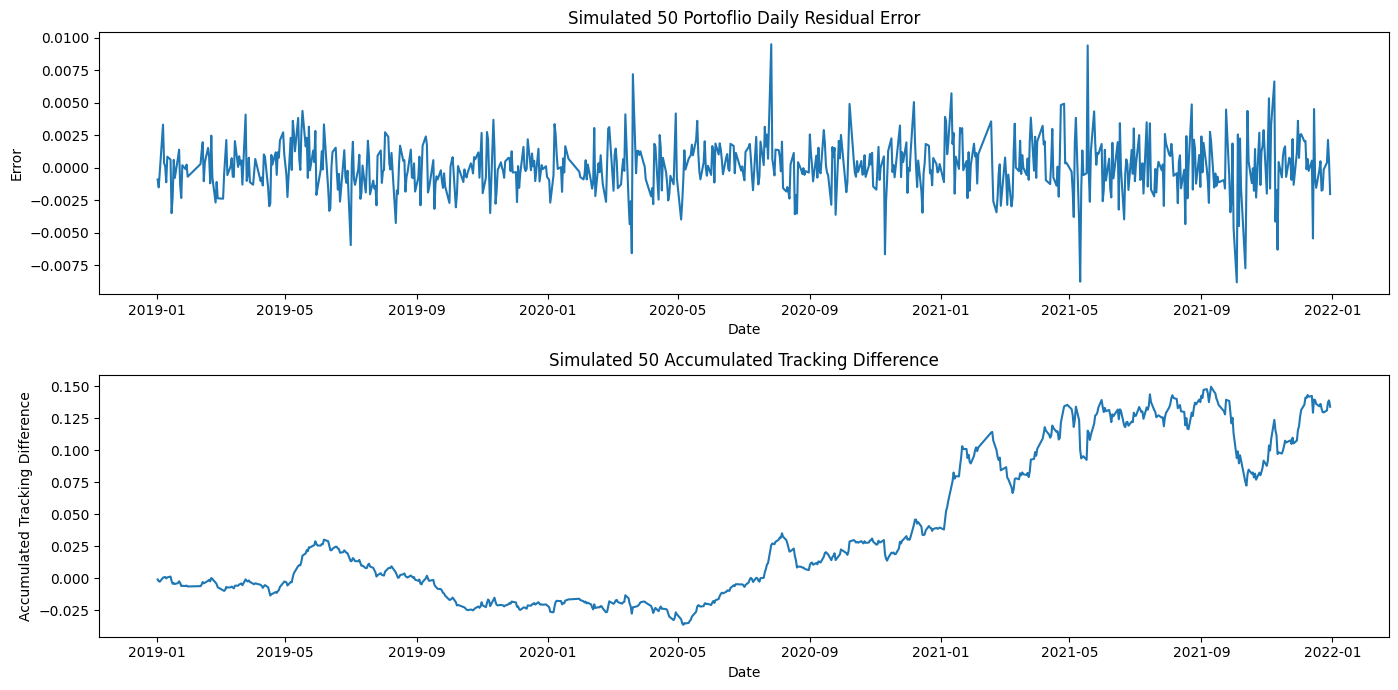

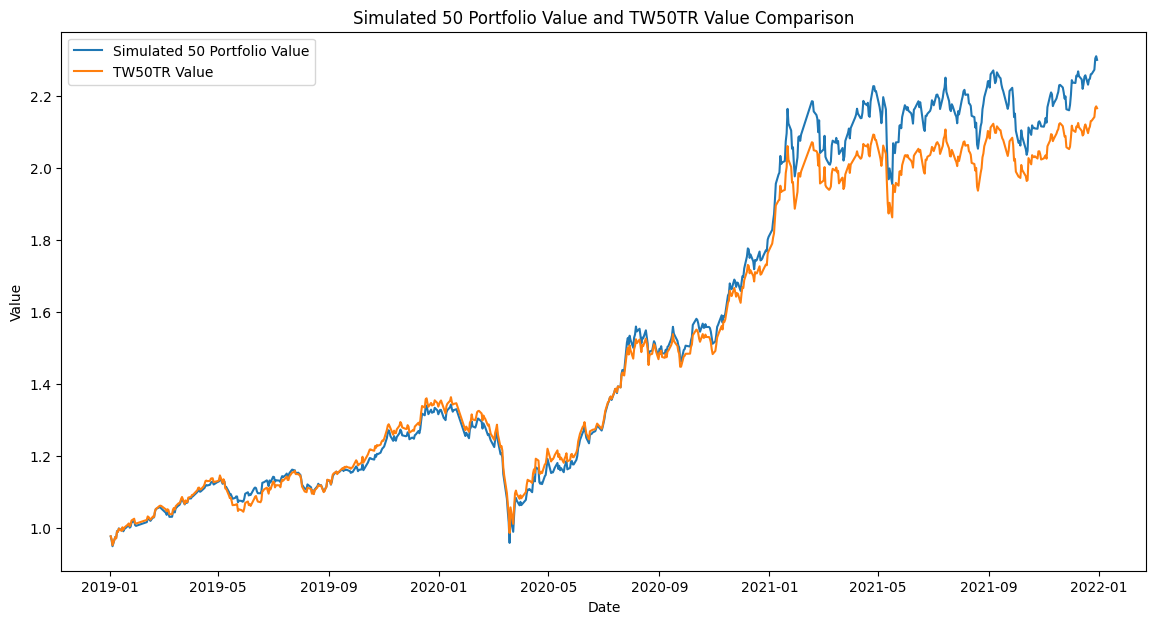

In [391]:
weighted_returns = mkt_ratio_data * cumulative_returns
result = pd.DataFrame(index = weighted_returns.index)
result['Simulated_Portfolio_CumReturn'] = weighted_returns.sum(axis=1)
result['Portfolio_Value']= 1
#%%
start_date_value = 1
for i in range(len(rebalance_dates) - 1):
    start_date = rebalance_dates[i]
    end_date = rebalance_dates[i + 1] - pd.Timedelta(days=1)  # 減一天以排除下一個調整日
    period_return = result['Simulated_Portfolio_CumReturn'][start_date:end_date]
    period_value = start_date_value * (period_return.add(1))
    result['Portfolio_Value'][start_date:end_date] = period_value
    if i < len(rebalance_dates) - 2:
        # 尋找 start_date 的前一個有效交易日
        previous_trading_day_index = data.index.get_loc(rebalance_dates[i + 1]) - 1
        previous_trading_day = data.index[previous_trading_day_index]
        # 從前一個有效交易日取得組合價值
        start_date_value = result['Portfolio_Value'][previous_trading_day]


#%%
result = pd.concat([result, TW50_TR], axis=1)
result['Simulated_Portfolio_Return'] = result['Portfolio_Value'].pct_change()
result = result.loc[f'{start}' : f'{end}']
result = result.dropna()
result['TW50TR_Value'] = result['TW50TR_Return'].add(1).cumprod()
result['Portfolio_Value'] = result['Simulated_Portfolio_Return'].add(1).cumprod()
result['Residual Error'] = result['Simulated_Portfolio_Return'] - result['TW50TR_Return']
#result['Residual Stdev'] = result['Residual Error'].rolling(window = 250).std() * 250**(1/2)
result['Residual Stdev'] = result['Residual Error'].std() * 250**(1/2)
result['Accumulated Difference'] = result['Portfolio_Value'] - result['TW50TR_Value']

sum_error = abs(result['Residual Error']).sum()
residual_stdev = result['Residual Stdev'][-1]

#計算Annual Diff

accumulated_diff = (result['Accumulated Difference'][-1] + 1) **(1/(len(result['Portfolio_Value'])/250)) - 1

print('Sum of Abs Residual Error', sum_error)
print('Annual Tracking Error', residual_stdev)
print('Annual Tracking Difference', accumulated_diff)

#%%

# 繪製Residual Error的圖
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(result.index, result['Residual Error'])
plt.title(f'Simulated {number_stocks} Portoflio Daily Residual Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.subplot(2, 1 ,2)
plt.plot(result.index, result['Accumulated Difference'])
plt.title(f'Simulated {number_stocks} Accumulated Tracking Difference')
plt.xlabel('Date')
plt.ylabel('Accumulated Tracking Difference')
# 調整子圖間距
plt.tight_layout()
plt.savefig(f'{number_stocks}_Residual.png')
plt.show()


# 繪製Portfolio Value和TW50TR Value在同一張圖
plt.figure(figsize=(14, 7))
plt.plot(result.index, result['Portfolio_Value'], label=f'Simulated {number_stocks} Portfolio Value')
plt.plot(result.index, result['TW50TR_Value'], label='TW50TR Value')
plt.title(f'Simulated {number_stocks} Portfolio Value and TW50TR Value Comparison')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
#plt.yscale('log',base = 2)
plt.savefig(f'{number_stocks}_Value.png')
plt.show()

In [397]:
output = pd.DataFrame(columns=['Date', '50_Portfolio_Daily_Return', 'TW50TR_Daily_Return'], index = result.index)
output['Date'] = result.index
output['50_Portfolio_Daily_Return'] = result['Simulated_Portfolio_Return']
output['TW50TR_Daily_Return'] = result['TW50TR_Return']
output.to_csv(f'{number_stocks}_Portfolio&TW50_Return.csv')

In [396]:
result['Simulated_Portfolio_Return']

年月日
2019-01-02   -0.023188
2019-01-03   -0.010221
2019-01-04   -0.017455
2019-01-07    0.026990
2019-01-08   -0.003223
                ...   
2021-12-24    0.000309
2021-12-27    0.005258
2021-12-28    0.013878
2021-12-29    0.002571
2021-12-30   -0.004389
Name: Simulated_Portfolio_Return, Length: 731, dtype: float64

累積超額報酬(%):  6.556886793499245%


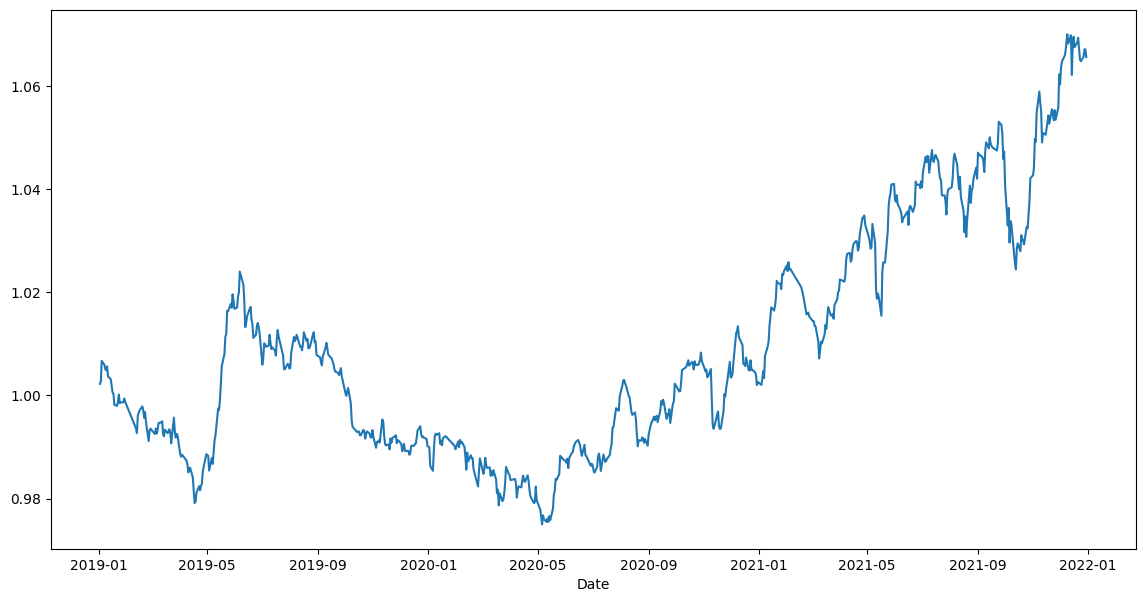

In [379]:
#計算投組超額報酬
plt.figure(figsize=(14, 7))
plt.xlabel('Date')
result['Excess Return'] = result['Simulated_Portfolio_Return'] - result['TW50TR_Return']
excess_return = result['Excess Return'].add(1).cumprod()
plt.plot(result.index, excess_return)
print('累積超額報酬(%): ', f'{excess_return[-1] * 100 - 100}%')

C:\Users\user\AppData\Local\Temp\ipykernel_10784\572367097.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_returns[df_name]['Portfolio_Value'][start_date:end_date] = period_value


P1 Sum of Abs Residual Error 2.449461711862988
P1 Annual Tracking Error 0.06883305223904254
P1 Annual Tracking Difference -0.07977274430267034


C:\Users\user\AppData\Local\Temp\ipykernel_10784\572367097.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_returns[df_name]['Portfolio_Value'][start_date:end_date] = period_value


P2 Sum of Abs Residual Error 2.696622583338816
P2 Annual Tracking Error 0.07740833453714875
P2 Annual Tracking Difference -0.12550124048442857


C:\Users\user\AppData\Local\Temp\ipykernel_10784\572367097.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_returns[df_name]['Portfolio_Value'][start_date:end_date] = period_value


P3 Sum of Abs Residual Error 2.7954772005247173
P3 Annual Tracking Error 0.0793240007744055
P3 Annual Tracking Difference -0.06183338813637895


C:\Users\user\AppData\Local\Temp\ipykernel_10784\572367097.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_returns[df_name]['Portfolio_Value'][start_date:end_date] = period_value


P4 Sum of Abs Residual Error 2.992160519999472
P4 Annual Tracking Error 0.08272998872044784
P4 Annual Tracking Difference -0.024953230545394445


C:\Users\user\AppData\Local\Temp\ipykernel_10784\572367097.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_returns[df_name]['Portfolio_Value'][start_date:end_date] = period_value


P5 Sum of Abs Residual Error 3.096644823054987
P5 Annual Tracking Error 0.08754247314009055
P5 Annual Tracking Difference -0.1970655498338525


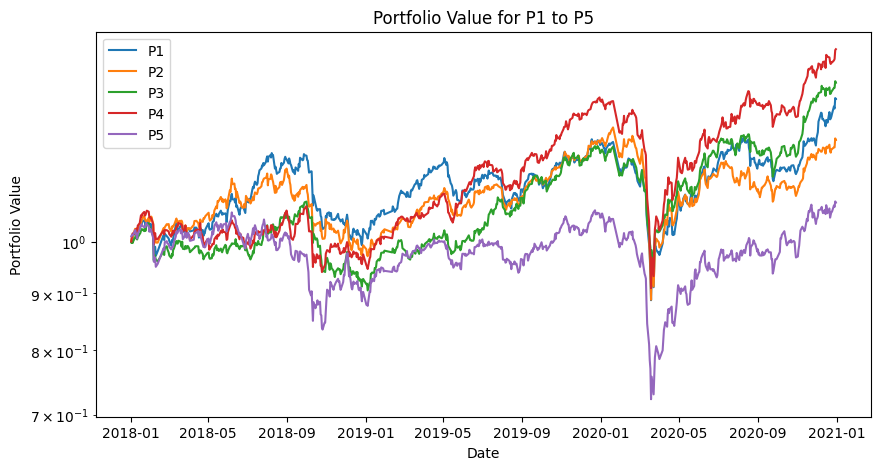

In [366]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#%%
#寫法邏輯
#IVOL_weights = IVOL_weights(rebalance_date, top_stocks_name, period_TSE_Stock_Price, period_TW50_TR)
#input 1: 調整日的日期
#input 2: input tickers need to be sorted
#input 3: 將調整日的日期往前一年作為訓練選股
#input 4: 計算這些股票的選股
#input 5: return data
#data: slice return data
#def rebalance date, tickers, return data, 
#output: 

#years = [2017, 2018, 2019, 2020, 2021]
#dt_years_first_day = [pd.to_datetime(year, format='%Y') for year in years]
#dt_years_end_day = [pd.to_datetime(year + 1, format='%Y') - DateOffset(days=1) for year in years]



def IVOL_weights2(backtest_end_day, tickers, period_TSE_TR, period_TW50_TR, top_weights):
    #backtest_first_day = backtest_end_day - DateOffset(years=1)
    data_return = pd.concat([period_TSE_TR, period_TW50_TR],axis=1)
    date = str(data_return.index[len(data_return)-1]).split(' ')[0]
    if date == '2002-07-04':
        date = '2002-07-05'
    
    first_q_dates = data_return.groupby(data_return.index.to_period('Q')).apply(lambda x: x.index[0])
    first_q_dates = sorted(first_q_dates.tolist())

    end_q_dates = data_return.groupby(data_return.index.to_period('Q')).apply(lambda x: x.index[-1])
    end_q_dates = sorted(end_q_dates.tolist())
    
    first_m_dates = data_return.groupby(data_return.index.to_period('M')).apply(lambda x: x.index[0])
    first_m_dates = sorted(first_m_dates.tolist())
    
    end_m_dates = data_return.groupby(data_return.index.to_period('M')).apply(lambda x: x.index[-1])
    end_m_dates = sorted(end_m_dates.tolist())
    
    prev_rebalance_date = data_return.index[0]
    monthly_returns = [] #用來儲存每月的報酬
    
    for end_m_date in end_m_dates:
        
        period_return = data_return[prev_rebalance_date: end_m_date]
        period_cumulative_return = period_return.add(1).prod()-1
        monthly_returns.append(period_cumulative_return)        
        
        # Update the prev_rebalance_date for the next interval
        prev_rebalance_date = end_m_date + DateOffset(days=1)
    
    # 初始化 LinearRegression 模型
    lm = LinearRegression()
    
    # 創建一個儲存MSE的字典
    residual_dict_3M = {}
    residual_dict_6M = {}
    residual_dict_12M = {}
    
    # 假設 monthly_return 是一個包含 12 個 pandas Series 的列表
    # 每個 Series 包含多列（一列代表一個日期）和多行（一行代表一個股票）
    
    # 獲取所有的股票名稱 (排除 "TSE")
    stock_names = monthly_returns[0].drop("TW50TR_Return").index

    # 進行迴歸分析
    for stock in stock_names:
        y = np.array([monthly_return["TW50TR_Return"] for monthly_return in monthly_returns])
        X = np.array([monthly_return[stock] for monthly_return in monthly_returns]).reshape(-1, 1)
        
        # 訓練模型
        lm.fit(X, y)
        
        # 進行預測
        y_pred = lm.predict(X)
        
        # 計算MSE
        residual = y_pred - y
        
        # 將MSE儲存到字典
        residual_dict_12M[stock] = residual.std()
        
        y = y[-6:]
        X = X[-6:]
        
        # 訓練模型
        lm.fit(X, y)
        
        # 進行預測
        y_pred = lm.predict(X)
        
        # 計算MSE
        residual = y_pred - y
        
        # 將MSE儲存到字典
        residual_dict_6M[stock] = residual.std()

        y = y[-3:]
        X = X[-3:]
        
        # 訓練模型
        lm.fit(X, y)
        
        # 進行預測
        y_pred = lm.predict(X)
        
        # 計算MSE
        residual = y_pred - y
        
        # 將MSE儲存到字典
        residual_dict_3M[stock] = residual.std()

    stdev_dict_3M = {}
    stdev_dict_6M = {}
    stdev_dict_12M = {}
    
    for stock in stock_names:
        stock_return = data_return.loc[:,stock]
        quarter_stdev = stock_return[-60:].std()
        semiannual_stdev = stock_return[-120:].std()
        year_stdev = stock_return.std()
        stdev_dict_3M[stock] = quarter_stdev
        stdev_dict_6M[stock] = semiannual_stdev
        stdev_dict_12M[stock] = year_stdev
    
    
    cummulative_return_3M = data_return.loc[:,stock_names][:-60].add(1).prod() - 1
    cummulative_return_6M = data_return.loc[:,stock_names][:-120].add(1).prod() - 1
    cummulative_return_12M = data_return.loc[:,stock_names][:].add(1).prod() - 1
    
    #將MA因子改成市值因子!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # MA60_price = data_return.loc[:,stock_names][:].add(1).cumprod()
    # MA60 = MA60_price.rolling(window = 60).mean()
    # MA60_result = MA60_price.iloc[-1] / MA60.iloc[-1]
    mkt_ratio = pd.read_csv('TEJ_50_mkt_ratio.txt', delimiter='\t')
    mkt_ratio['年月日'] = pd.to_datetime(mkt_ratio['年月日'], format='%Y/%m/%d')
    mkt_ratio['成份股'] = mkt_ratio['成份股'].str.split(' ', expand=True)[0] + '.TW'
    filtered_mkt_ratio = mkt_ratio[mkt_ratio['成份股'].isin(tickers)]
    #篩選特定日期的資料
    filtered_mkt_ratio = filtered_mkt_ratio[filtered_mkt_ratio['年月日'] == str(date)]
    filtered_mkt_ratio = filtered_mkt_ratio.set_index('成份股', drop=True)
    MA60_result = filtered_mkt_ratio['前日市值比重']
    
    #%%
    # 將 MSE 字典轉換為 DataFrame 以便查看
    residual_dict_3M = pd.DataFrame(list(residual_dict_3M.items()), columns=['Stock', 'Residual'])
    residual_dict_6M = pd.DataFrame(list(residual_dict_6M.items()), columns=['Stock', 'Residual'])
    residual_dict_12M = pd.DataFrame(list(residual_dict_12M.items()), columns=['Stock', 'Residual'])

    #print(residual_dict)
    
    # 對 Residual 列進行排序，預設是升序
    residual_dict_3M = residual_dict_3M.sort_values(by='Residual')
    residual_dict_6M = residual_dict_6M.sort_values(by='Residual')
    residual_dict_12M = residual_dict_12M.sort_values(by='Residual')
    
    residual_dict_3M.set_index('Stock', inplace=True)
    residual_dict_6M.set_index('Stock', inplace=True)
    residual_dict_12M.set_index('Stock', inplace=True)
    
    residual_dict_3M['RANK'] = residual_dict_3M['Residual'].rank()
    residual_dict_6M['RANK'] = residual_dict_6M['Residual'].rank()
    residual_dict_12M['RANK'] = residual_dict_12M['Residual'].rank()

    residual_dict = pd.DataFrame(residual_dict_3M['RANK'] + residual_dict_6M['RANK'] + residual_dict_12M['RANK'])
#%%    
    # 將 MOM 字典轉換為 DataFrame 以便查看
    cummulative_return_3M = pd.DataFrame(list(cummulative_return_3M.items()), columns=['Stock', 'MOM'])
    cummulative_return_6M = pd.DataFrame(list(cummulative_return_6M.items()), columns=['Stock', 'MOM'])
    cummulative_return_12M = pd.DataFrame(list(cummulative_return_12M.items()), columns=['Stock', 'MOM'])
    #print(residual_dict)
    
    # 對 MOM 列進行排序，預設是升序
    cummulative_return_3M = cummulative_return_3M.sort_values(by='MOM', ascending= False)
    cummulative_return_6M = cummulative_return_6M.sort_values(by='MOM', ascending= False)
    cummulative_return_12M = cummulative_return_12M.sort_values(by='MOM', ascending= False)
    
    cummulative_return_3M.set_index('Stock', inplace=True)
    cummulative_return_6M.set_index('Stock', inplace=True)
    cummulative_return_12M.set_index('Stock', inplace=True)
    
    cummulative_return_3M['RANK'] = cummulative_return_3M['MOM'].rank(ascending = False)
    cummulative_return_6M['RANK'] = cummulative_return_6M['MOM'].rank(ascending = False)
    cummulative_return_12M['RANK'] = cummulative_return_12M['MOM'].rank(ascending = False)

    MOM_dict = pd.DataFrame(cummulative_return_3M['RANK'] + cummulative_return_6M['RANK'] + cummulative_return_12M['RANK'])

    # 均線因子
    MA60_df = pd.DataFrame(list(MA60_result.items()), columns=['Stock', 'MA'])
    MA60_df = MA60_df.sort_values(by='MA', ascending= False)    
    MA60_df.set_index('Stock', inplace=True)
    MA60_df['RANK'] = MA60_df['MA'].rank(ascending = False)
    MA_dict = pd.DataFrame(MA60_df['RANK'])
    

#%%    
    stdev_dict_3M = pd.DataFrame(list(stdev_dict_3M.items()), columns=['Stock', 'Stdev'])
    stdev_dict_6M = pd.DataFrame(list(stdev_dict_6M.items()), columns=['Stock', 'Stdev'])
    stdev_dict_12M = pd.DataFrame(list(stdev_dict_12M.items()), columns=['Stock', 'Stdev'])

    
    # 對 Residual 列進行排序，預設是升序
    stdev_dict_3M = stdev_dict_3M.sort_values(by='Stdev')
    stdev_dict_6M = stdev_dict_6M.sort_values(by='Stdev')
    stdev_dict_12M = stdev_dict_12M.sort_values(by='Stdev')
    
    stdev_dict_3M.set_index('Stock', inplace=True)
    stdev_dict_6M.set_index('Stock', inplace=True)
    stdev_dict_12M.set_index('Stock', inplace=True)
    
    stdev_dict_3M['RANK'] = stdev_dict_3M['Stdev'].rank()
    stdev_dict_6M['RANK'] = stdev_dict_6M['Stdev'].rank()
    stdev_dict_12M['RANK'] = stdev_dict_12M['Stdev'].rank()

    stdev_dict = pd.DataFrame(0*stdev_dict_3M['RANK'] + 0*stdev_dict_6M['RANK'] + stdev_dict_12M['RANK'])


    #新增市場價值因子
    pb_data = pd.read_csv('total_mkt_data.csv')
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    # 將日期格式轉換成 'Jun-05' 格式的字符串
    formatted_date = date_obj.strftime('%b-%y')


    pb_data = pd.read_csv('total_mkt_data.csv')
    pb_data['成份股'] = pb_data['code'].apply(lambda x: str(x) + '.TW' if isinstance(x, int) else x)
    filtered_pb_data = pb_data[pb_data['成份股'].isin(tickers)]
    #篩選特定日期的資料
    filtered_pb_data = filtered_pb_data[filtered_pb_data['年月'] == str(formatted_date)]
    filtered_pb_data = filtered_pb_data.set_index('成份股', drop=True)
    pb_result = filtered_pb_data['當季季底P/B']

    pb_df = pd.DataFrame(list(pb_result.items()), columns=['Stock', 'PB'])
    pb_df = pb_df.sort_values(by='PB', ascending= True)    
    pb_df.set_index('Stock', inplace=True)
    pb_df['RANK'] = pb_df['PB'].rank(ascending = True)
    pb_dict = pd.DataFrame(pb_df['RANK'])
    if len(pb_dict) == 0:
        pb_dict = MA_dict



    # residual_dict = stdev_dict*1 + residual_dict*1 + MOM_dict*1 + MA_dict*1
    residual_dict = MOM_dict*0 + MA_dict*0 + pb_dict * 1

    #%%
    # 使用 qcut 將股票按照 'Residual' 列分成 5 組
    residual_dict = residual_dict.sort_values(by='RANK')
    residual_dict['Group'] = pd.qcut(residual_dict['RANK'], 5, labels=range(1, 6, 1))
    
    
    weights_df = pd.DataFrame()
    weights_df.index = residual_dict.index
    for i in range(1, 6, 1):
        residual_dict.loc[residual_dict['Group'] == i, 'change_weights'] = 1/len(residual_dict[residual_dict['Group'] == i])
        weights_df[f'P{i}'] = residual_dict.loc[residual_dict['Group'] == i, 'change_weights']
        weights_df[f'P{i}'] = weights_df[f'P{i}'].fillna(0)

    residual_dict['change_weights'] = residual_dict['change_weights'].fillna(0)

    return weights_df


# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
#import re

number_stocks = 250
start = '2018-01-01'
end = '2020-12-31'

mkt_ratio_data = pd.read_csv('TSE_weights.txt', delimiter='\t')
TSE_Stocks_TR = pd.read_csv('TSE_Total_Stocks_Price.txt', delimiter='\t', dtype={'證券代碼': str})
indates_data = pd.read_csv('indates.txt', delimiter='\t')
exdates_data = pd.read_csv('exdates.txt', delimiter='\t')
##### This is TSE #####

# 處理證券代碼，只保留數字部分
TSE_Stocks_TR = TSE_Stocks_TR.drop(columns =['簡稱'])

# 將年月日轉換為日期格式
TSE_Stocks_TR['年月日'] = pd.to_datetime(TSE_Stocks_TR['年月日'])

# 設置年月日為索引並進行透視
TSE_Stocks_TR = TSE_Stocks_TR.pivot(index='年月日', columns='證券代碼', values='收盤價(元)')
TSE_Stocks_TR = TSE_Stocks_TR.pct_change().fillna(0)
TSE_Stocks_TR.columns = [column + '.TW' for column in TSE_Stocks_TR.columns]

##### This is dates_data #####

indates = [str(date)[0:4] + '/' + str(date)[4:6] + '/' + str(date)[6:8] for date in indates_data['事件日']]
exdates = [str(date)[0:4] + '/' + str(date)[4:6] + '/' + str(date)[6:8] for date in exdates_data['事件日']]
indates = pd.Series(pd.DatetimeIndex(indates))
exdates = pd.Series(pd.DatetimeIndex(exdates))

def calculate_entry_year_month(indate):
    year, month = indate.year, indate.month + 2
    if month > 12:
        year += 1
        month -= 12
    return pd.Series([year, month])

inmonths = indates.apply(calculate_entry_year_month)
first_m_dates = TSE_Stocks_TR.groupby(TSE_Stocks_TR.index.to_period('M')).apply(lambda x: x.index[0])
inmonths_period = inmonths.apply(lambda x: pd.Period(year=x[0], month=x[1], freq='M'),axis=1)
inmonths_period = inmonths_period.unique()

#first_m_dates_period = first_m_dates.index

entry_dates = []
for period in inmonths_period:
    matching_dates = [first_m_date for first_m_date in first_m_dates if first_m_date.to_period('M') == period]
    entry_dates.extend(matching_dates)

#exdates = pd.Series()
dates = pd.concat([pd.Series(entry_dates), exdates],axis = 0)
rebalance_dates = pd.Series(dates).unique()
# 每次重置的日期
rebalance_dates = np.sort(rebalance_dates)
rebalance_dates = pd.to_datetime(rebalance_dates)


#%%
##### This is TW50_TR ####

TW50_TR = pd.read_csv('TSE_TR.txt', delimiter='\t')
#TW50_TR = TW50_TR[::-1]
TW50_TR.index = pd.to_datetime(TW50_TR['年月日'])

TW50_TR['TW50TR_Return'] = pd.to_numeric(TW50_TR['日報酬率 %'], errors='coerce') / 100
TW50_TR.drop(columns=['年月日', '證券代碼', '日報酬率 %'], inplace=True)

#%% This is mkt_ratio_data
# 刪除 "證券代碼" 這一欄

mkt_ratio_data.drop(columns=['證券代碼'], inplace=True)
mkt_ratio_data['成份股'] = mkt_ratio_data['成份股'].str.extract('([A-Za-z]?\d{4})')
mkt_ratio_data = mkt_ratio_data.pivot(index='年月日', columns='成份股', values='前日市值比重')
mkt_ratio_data.index = pd.to_datetime(mkt_ratio_data.index)
mkt_ratio_data.sort_index(ascending=True, inplace=True)
mkt_ratio_data.columns = [column + '.TW' for column in mkt_ratio_data.columns]
mkt_ratio_data = mkt_ratio_data/100
mkt_ratio_data = mkt_ratio_data.fillna(0)
#%%
rebalance_dates = rebalance_dates[rebalance_dates.isin(mkt_ratio_data.index)]

#將Rebalance Date至2004，這樣才可以計算低波動
rebalance_dates = rebalance_dates[100:]# + 300:] #100 or 400

rebalance_dates_mkt_ratio = mkt_ratio_data.loc[rebalance_dates]

##### 確保投組權重有其對應的個股報酬  #####
data = TSE_Stocks_TR
common_index = mkt_ratio_data.index.intersection(data.index)
mkt_ratio_data = mkt_ratio_data.loc[common_index]
data = data.loc[common_index]

common_columns = mkt_ratio_data.columns.intersection(data.columns)
mkt_ratio_data = mkt_ratio_data[common_columns]
data = data[common_columns]

#%%

factor_rebalance_weights = {}

for i in range(1, 6):
    df_name = f'rebalance_dates_weights_P{i}'
    factor_rebalance_weights[df_name] = pd.DataFrame(index= rebalance_dates_mkt_ratio.index , columns= mkt_ratio_data.columns)
    
# 遍歷每個調整日
for rebalance_date in rebalance_dates:
    if str(rebalance_date).split('-')[0] < '2017':
        continue

    # 獲取該日期的市值比重數據
    daily_mkt_ratio = mkt_ratio_data.loc[rebalance_date]
    
    # 排序市值比重，並剔除市值最小的10檔股票
    sorted_mkt_ratio = daily_mkt_ratio.sort_values(ascending=False)
    top_stocks = sorted_mkt_ratio[:number_stocks]  # 這會保留市值比重最大的40檔股票
    
    # 提取tickers name
    top_stocks_name = top_stocks.index.tolist()
    
    # 重新加權剩餘的股票
    top_weights = top_stocks / top_stocks.sum()
    
    # 計算因子投組
    # DateOffset(days = 1) 是為了不用到Future Data
    period_TSE_TR = TSE_Stocks_TR.loc[rebalance_date - DateOffset(years=1) : rebalance_date - DateOffset(days=1), top_stocks_name]
    period_TW50_TR = TW50_TR.loc[rebalance_date - DateOffset(years=1) : rebalance_date - DateOffset(days=1)]
    IVOL_weights_df = IVOL_weights2(rebalance_date, top_stocks_name, period_TSE_TR, period_TW50_TR, top_weights)
    

    # 假設 IVOL_weights 返回的 DataFrame 包含多個組別的權重
    for i in range(1, 6):
        group_name = f'P{i}'
        dict_name = f'rebalance_dates_weights_P{i}'
        top_weights = top_weights* 0 + IVOL_weights_df[group_name]
        factor_rebalance_weights[dict_name].loc[rebalance_date, top_weights.index] = top_weights
        

#%%

# 獲取 mkt_ratio_data 的完整日期範圍
all_dates = mkt_ratio_data.index
# 重建索引，包括所有日期
for i in range(1, 6):
    group_name = f'P{i}'
    dict_name = f'rebalance_dates_weights_P{i}'
    factor_rebalance_weights[dict_name] = factor_rebalance_weights[dict_name].fillna(0)
    factor_rebalance_weights[dict_name] = factor_rebalance_weights[dict_name].reindex(all_dates)
    factor_rebalance_weights[dict_name] = factor_rebalance_weights[dict_name].fillna(method='ffill')

# 將第一天和最後一天加入到調整日期中，以覆蓋所有可能的日期範圍
rebalance_dates = pd.Series(np.append(rebalance_dates,pd.Series(data.index[-1])+pd.Timedelta(days=1)))

# 創建一個空的 DataFrame 來存儲所有股票的累積報酬
cumulative_returns = pd.DataFrame(index=mkt_ratio_data.index, columns=common_columns)

# 計算每個調整日期區間的累積報酬
for i in range(len(rebalance_dates) - 1):
    start_date = rebalance_dates[i]
    end_date = rebalance_dates[i + 1] - pd.Timedelta(days=1)  # 減一天以排除下一個調整日
    period_data = data.loc[start_date:end_date]
    cumulative_returns_period = (period_data + 1).cumprod() - 1
    cumulative_returns.loc[start_date:end_date] = cumulative_returns_period

# 確保結果中沒有 NaN 值
cumulative_returns.dropna()

#計算
factor_returns = {}

for i in range(1, 6):
    df_name = f'factor_return_P{i}'
    dict_name = f'rebalance_dates_weights_P{i}'
    weighted_returns = factor_rebalance_weights[dict_name] * cumulative_returns
    factor_returns[df_name] = pd.DataFrame(index=mkt_ratio_data.index)
    factor_returns[df_name]['Simulated_Portfolio_CumReturn'] = weighted_returns.sum(axis=1)
    factor_returns[df_name]['Portfolio_Value'] = 1
    
    start_date_value = 1
    # 計算每個調整日期區間的累積報酬
    for m in range(len(rebalance_dates) - 1):
         start_date = rebalance_dates[m]
         end_date = rebalance_dates[m + 1] - pd.Timedelta(days=1)  # 減一天以排除下一個調整日
         period_return = factor_returns[df_name]['Simulated_Portfolio_CumReturn'][start_date:end_date]
         period_value = start_date_value * (period_return.add(1))
         factor_returns[df_name]['Portfolio_Value'][start_date:end_date] = period_value
         if m < len(rebalance_dates) - 2:
             # 尋找 start_date 的前一個有效交易日
             previous_trading_day_index = data.index.get_loc(rebalance_dates[m + 1]) - 1
             previous_trading_day = data.index[previous_trading_day_index]
             # 從前一個有效交易日取得組合價值
             start_date_value = factor_returns[df_name]['Portfolio_Value'][previous_trading_day]
            
    factor_returns[df_name] = pd.concat([factor_returns[df_name], TW50_TR['TW50TR_Return']], axis=1)
    factor_returns[df_name]['Simulated_Portfolio_Return'] = factor_returns[df_name]['Portfolio_Value'].pct_change()
    factor_returns[df_name] = factor_returns[df_name].loc[f'{start}' : f'{end}']
    factor_returns[df_name] = factor_returns[df_name].dropna()
    factor_returns[df_name]['TW50TR_Value'] = factor_returns[df_name]['TW50TR_Return'].add(1).cumprod()
    factor_returns[df_name]['Portfolio_Value'] = factor_returns[df_name]['Simulated_Portfolio_Return'].add(1).cumprod()
    factor_returns[df_name]['Residual Error'] = factor_returns[df_name]['Simulated_Portfolio_Return'] - factor_returns[df_name]['TW50TR_Return']
    factor_returns[df_name]['Residual Stdev'] = factor_returns[df_name]['Residual Error'].std() * 250**(1/2)
    factor_returns[df_name]['Accumulated Difference'] = factor_returns[df_name]['Portfolio_Value'] - factor_returns[df_name]['TW50TR_Value']
    
    sum_error = abs(factor_returns[df_name]['Residual Error']).sum()
    residual_stdev = factor_returns[df_name]['Residual Stdev'][-1]

    #計算Annual Diff
    
    accumulated_diff = (factor_returns[df_name]['Accumulated Difference'][-1] + 1) **(1/(len(factor_returns[df_name]['Portfolio_Value'])/250)) - 1
    
    print(f'P{i} Sum of Abs Residual Error', sum_error)
    print(f'P{i} Annual Tracking Error', residual_stdev)
    print(f'P{i} Annual Tracking Difference', accumulated_diff)

#%%
# 首先，創建一個圖形和軸
plt.figure(figsize=(10, 5))

# 循環遍歷每個 DataFrame 並在同一個軸上畫出 'Portfolio_Value'
for i in range(1, 6):
    # 從字典中獲取 DataFrame
    df = factor_returns[f'factor_return_P{i}']
    # 繪製 'Portfolio_Value' 列
    plt.plot(df.index, df['Portfolio_Value'], label=f'P{i}')

# 添加圖例
plt.yscale('log')
plt.legend()

# 添加標題和軸標籤
plt.title('Portfolio Value for P1 to P5')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')

# 顯示圖形
plt.show()